In [1]:
# importing libraries #

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io

from scipy import signal
from scipy.fftpack import fft, dct
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

import os
os.listdir('/kaggle/input/BloodPressureDataset')

['part_4.mat',
 'part_9.mat',
 'part_10.mat',
 'Samples',
 'part_11.mat',
 'part_3.mat',
 'part_1.mat',
 'part_8.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_2.mat',
 'part_12.mat']

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
sample_file = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')

sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [4]:
test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [5]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125

print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [6]:
sample_size = 125
ppg = []

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)( temp_length / sample_size)):
        temp_ppg = temp_mat[0, j * sample_size:(j+1) * sample_size]
        ppg.append(temp_ppg)

In [7]:
# SBP : Systolic Blood Pressure
# DBP : Diastolic Blood Pressue

ecg = []
bp = []
sbp = [] 
dbp = [] 
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)( temp_length / sample_size)):
        temp_ecg = temp_mat[2, j * size:(j+1) * size]
        temp_bp = temp_mat[1, j * size:(j+1) * size]
        max_value = max(temp_bp)
        min_value = min(temp_bp)

        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [8]:
# Reshaping the signal data from the ecg, ppg, and bp into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


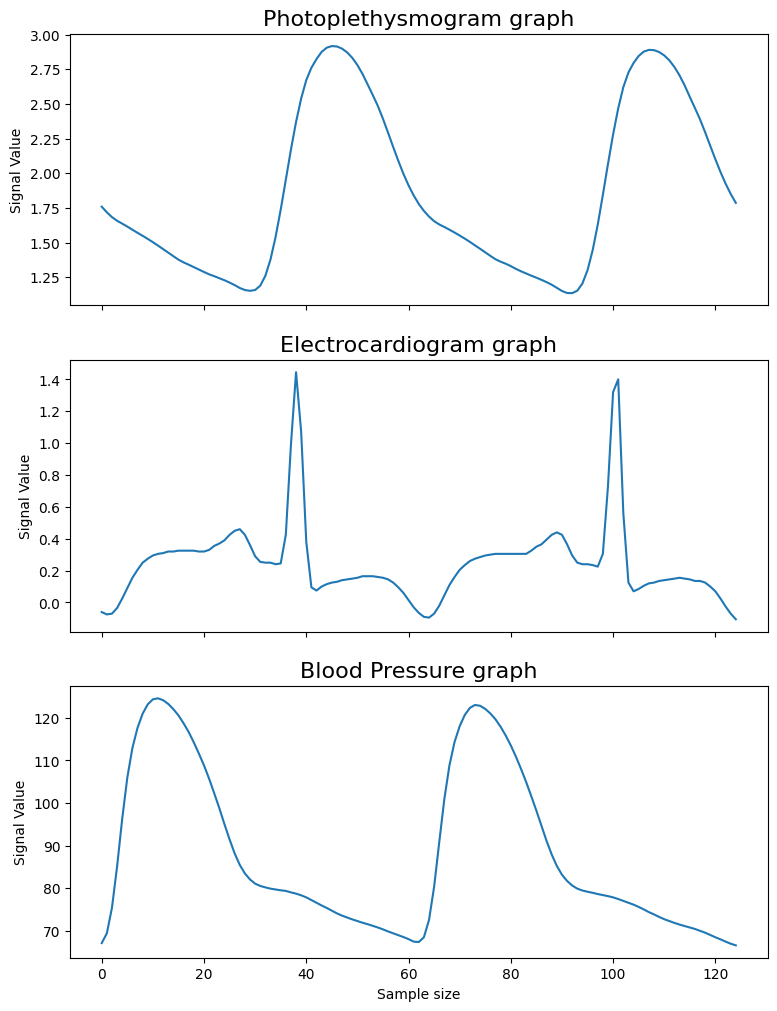

In [9]:
# plotting the signals

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('Photoplethysmogram graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('Electrocardiogram graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

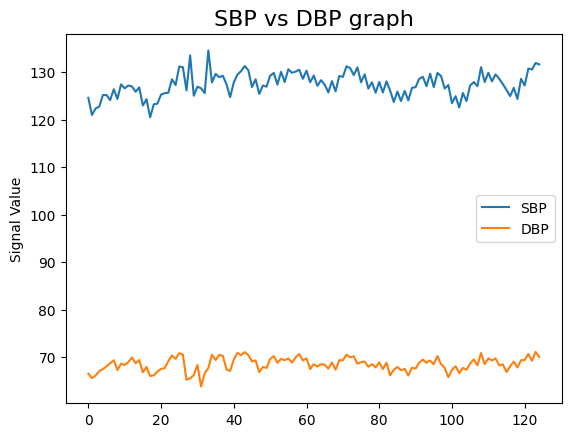

In [10]:
## Visualizing SBP and DBP

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

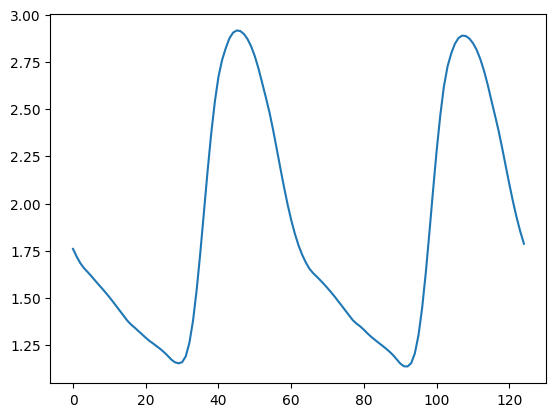

In [11]:
plt.plot(ppg[:125].squeeze())

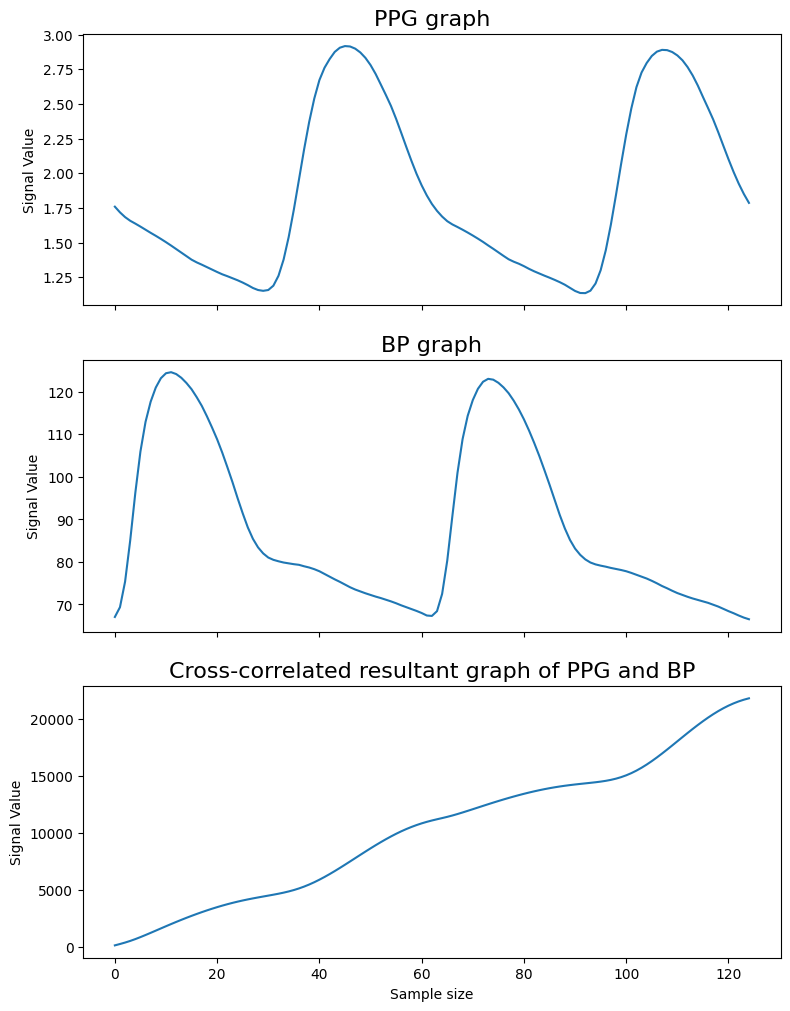

In [12]:
# Cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph of PPG and BP', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

In [13]:
# Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ppg)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
print(f'RMSE: {error}')

RMSE: 92.6029607182544


Linear Regression Model

In [14]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30)

In [15]:
#Kfold cross-validation
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]
    
    model = LinearRegression()
    model.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 27.34160875028264
Fold 1 RMSE: 27.329128361774742
Fold 2 RMSE: 27.347766180560797
Fold 3 RMSE: 27.335875237591072
Fold 4 RMSE: 27.35228161539952
Average RMSE over 5 folds: 27.34133202912175


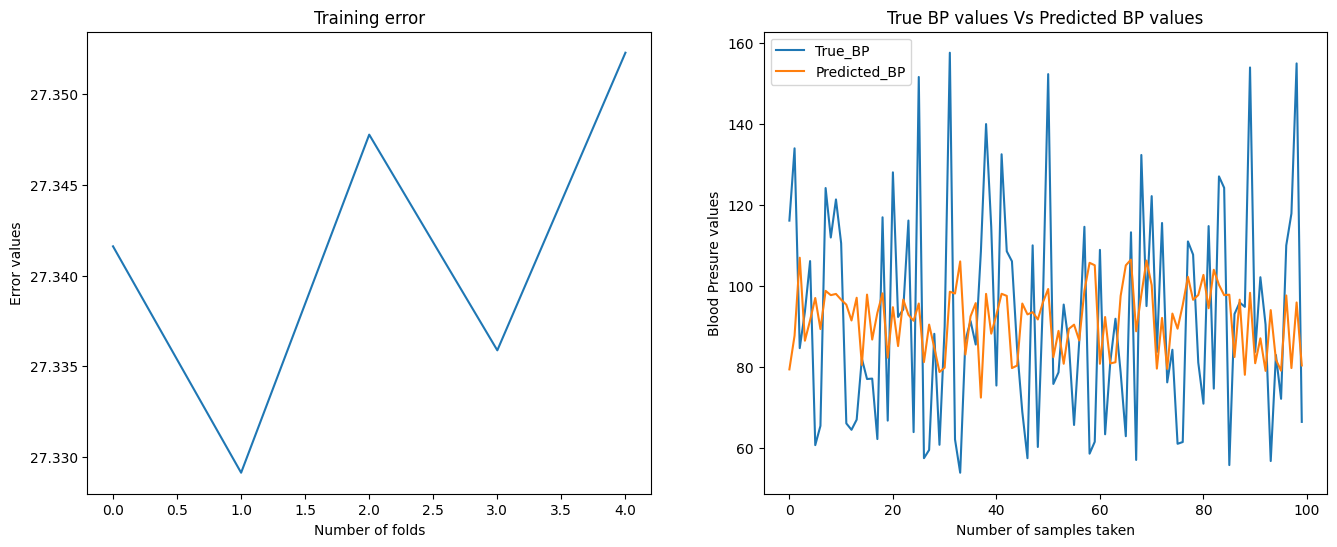

In [16]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("Training error")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("True BP values Vs Predicted BP values")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('Blood Presure values')
ax[1].plot(val_target[:100]) 
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [17]:
# Predicting on the test set
test_predictions = model.predict(X_test[:1000000])
test_error = rmse(y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

Error on test set predictions: 27.315423453224383


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [19]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512)) 
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))    
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Dense(num_class))    
    model.add(Activation('linear'))
    
    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [20]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2048      
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                3

In [21]:
# Training the model
history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    y_train[:1000000].squeeze(),
                    epochs=20,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/20
7813/7813 [==============================] - 128s 16ms/step - loss: 22.2271 - mean_absolute_error: 22.7219
Epoch 2/20
7813/7813 [==============================] - 127s 16ms/step - loss: 20.7468 - mean_absolute_error: 21.2411
Epoch 3/20
7813/7813 [==============================] - 129s 16ms/step - loss: 20.5259 - mean_absolute_error: 21.0203
Epoch 4/20
7813/7813 [==============================] - 127s 16ms/step - loss: 20.3574 - mean_absolute_error: 20.8516
Epoch 5/20
7813/7813 [==============================] - 119s 15ms/step - loss: 20.2294 - mean_absolute_error: 20.7236
Epoch 6/20
7813/7813 [==============================] - 119s 15ms/step - loss: 20.0981 - mean_absolute_error: 20.5923
Epoch 7/20
7813/7813 [==============================] - 117s 15ms/step - loss: 19.9932 - mean_absolute_error: 20.4874
Epoch 8/20
7813/7813 [==============================] - 116s 15ms/step - loss: 19.8868 - mean_absolute_error: 20.3810
Epoch 9/20
7813/7813 [==============================] - 

In [22]:
#Predicting on the test set using the nn(neural network) model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

31250/31250 [==============================] - 93s 3ms/step
Neural Net RMSE: 26.01345887109454


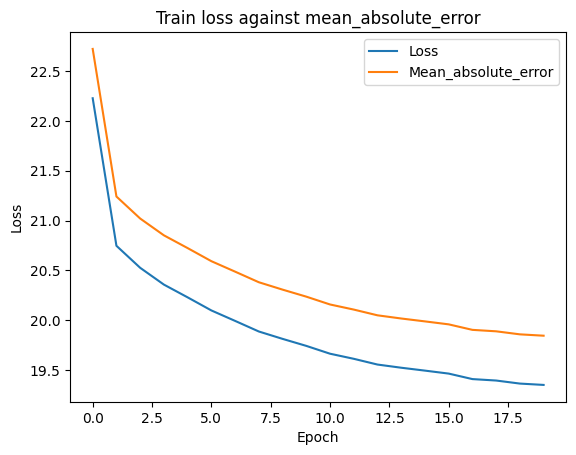

In [23]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

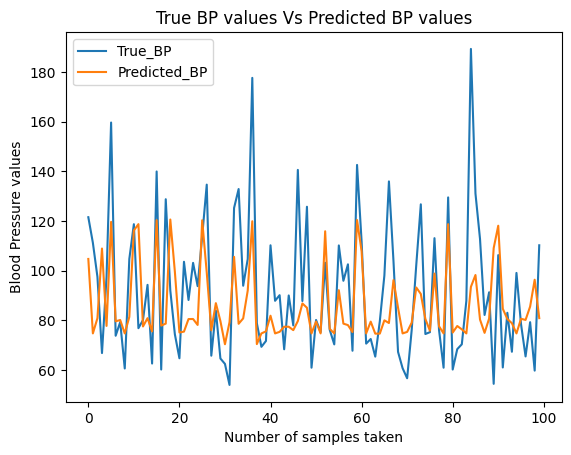

In [24]:
# Visualize predicted BP and the True BP
plt.title("True BP values Vs Predicted BP values")
plt.xlabel('Number of samples taken')
plt.ylabel('Blood Pressure values')
plt.plot(y_test[:100])
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])

In [25]:
model.save("model.h5")